<a href="https://colab.research.google.com/github/Mihan0207/Random_Forest_Bank_Marketing/blob/main/024_Md%20Mushfiqur%20Rahman_Random%20Forest%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Marketing — Random Forest Classifier

This notebook implements a full **Random Forest** pipeline on the UCI Bank Marketing dataset. It includes:
- Data loading via `ucimlrepo` if not present.
- Preprocessing: target encoding, leakage-aware column handling, outlier clipping, categorical one-hot encoding.
- Proper data splitting: **train / validation / test** (test kept unseen until the end).
- **Baseline** Random Forest and **hyperparameter tuning** with cross-validation.
- Model performance with **confusion matrix**, **ROC curve**, **AUC**, **accuracy**, **precision**, **recall**, **F1**.


### Why Random Forest?
Random Forests are robust, handle non-linearities and interactions automatically, and work well with mixed feature types after one-hot encoding. They offer strong out-of-the-box performance and calibrated feature importance signals without heavy feature scaling. This makes them suitable for bank deposit subscription prediction where relationships can be complex and not strictly linear.

In [ ]:
# %% [code]
# %% [code] Imports and setup
# Core libraries
import numpy as np
import pandas as pd

# Modeling utilities
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [ ]:
def print_header(text):
    """Prints a header with a separator."""
    print("\n" + "="*50)
    print(text)
    print("="*50)

In [ ]:
# %% [code]
# %% [code] Load data
# This cell will:
# 1) Use an existing 'bank_data' DataFrame if it already exists in the runtime.
# 2) Otherwise, try to fetch the official UCI dataset via ucimlrepo.
try:
    # If a previous cell in your Colab defined bank_data, we use it directly
    bank_data
    print_header("Using existing 'bank_data' from runtime")
except NameError:
    print_header("Fetching dataset via ucimlrepo")
    from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets


Fetching dataset via ucimlrepo


In [ ]:

# Normalize common column names for consistency
bank_data=pd.concat([X,y],axis=1)

bank_data.rename(columns={'pdays': 'passed_days', 'poutcome': 'previous_outcome', 'y': 'subscription'}, inplace=True)
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'passed_days', 'previous', 'previous_outcome', 'subscription'],
      dtype='object')

In [ ]:
# %% [code]
# %% [code] Basic clean-up and target encoding
# Convert the target to binary 1/0. Assumes 'subscription' with values like 'yes'/'no'.
bank_data['subscription_encoded'] = bank_data['subscription'].apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
# Known data leakage: 'duration' records call duration, which is only known after the call.
# Standard practice is to DROP 'duration' to avoid overly optimistic models.
if 'duration' in bank_data.columns:
    bank_data = bank_data.drop(columns=['duration'])

In [ ]:
bank_data.isna().sum()

,0
age,0
job,288
marital,0
education,1857
default,0
balance,0
housing,0
loan,0
contact,13020
day_of_week,0


In [ ]:
bank_data.duplicated().sum()

np.int64(16)

In [ ]:
# Data cleaning and Preprocessing

In [ ]:
# Handle obvious NAs
bank_data['job'] = bank_data['job'].fillna(bank_data['job'].mode()[0])
bank_data['education'] = bank_data['education'].fillna(bank_data['education'].mode()[0])
bank_data['contact'] = bank_data['contact'].fillna('unknown')

In [ ]:
# Dropping Column for too many unknowns. Insignificant to the outcome
bank_data.drop(columns=['previous_outcome'], inplace=True, errors='ignore')

In [ ]:
# %% [code] Outlier handling and feature engineering (pre-baseline)
# Clip numeric outliers to mitigate extreme values without removing rows.
balance_mean=bank_data['balance'].mean()
balance_std=bank_data['balance'].std()
bank_data=bank_data[bank_data['balance']<(balance_mean+2*balance_std)]
bank_data = bank_data[bank_data['balance'] >= 0]

In [ ]:
# %% [code]
# %% [code] Train / Validation / Test split
# We first set X and y, then split 70/30 into train_val and test (stratified).
# Then split train_val 80/20 into train and validation.

features = [c for c in bank_data.columns if c not in ['subscription','subscription_encoded']]
X_all = bank_data[features].copy()
y_all = bank_data['subscription_encoded'].copy()

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_all, y_all, test_size=0.30, random_state=42, stratify=y_all)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=42, stratify=y_train_val)

print_header("Split sizes")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)



Split sizes
Train: (22387, 14) Val: (5597, 14) Test: (11994, 14)


In [ ]:
# %% [code]
# %% [code] Preprocessing pipeline
# One-hot encode categoricals. Scale numerics (not required for RF, but harmless and keeps pipeline consistent).

categorical_cols_current = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols_current = X_train.select_dtypes(include=['number']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols_current),
        ('num', StandardScaler(), numeric_cols_current),
    ], remainder='drop'
)

preprocess

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month']),
                                ('num', StandardScaler(),
                                 ['age', 'balance', 'day_of_week', 'campaign',
                                  'passed_days', 'previous'])])


Baseline Validation Metrics
Accuracy: 0.8811863498302662
Precision: 0.5406976744186046
Recall: 0.13696612665684832
F1: 0.21856639247943596
ROC-AUC: 0.7830327533553219

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.94      4918
           1       0.54      0.14      0.22       679

    accuracy                           0.88      5597
   macro avg       0.72      0.56      0.58      5597
weighted avg       0.85      0.88      0.85      5597



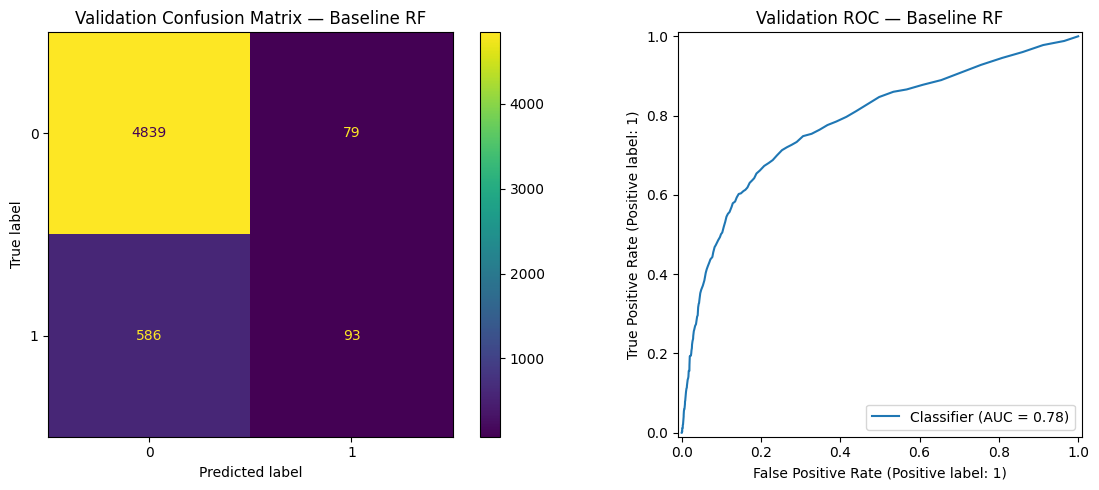

In [ ]:
# %% [code]
# %% [code] Baseline Random Forest (no tuning)
rf_baseline = Pipeline([
    ('prep', preprocess),
    ('rf', RandomForestClassifier(random_state=42, n_estimators=200, class_weight='balanced'))
])

rf_baseline.fit(X_train, y_train)

y_val_pred = rf_baseline.predict(X_val)
y_val_proba = rf_baseline.predict_proba(X_val)[:,1]

print_header("Baseline Validation Metrics")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("\nClassification report:\n", classification_report(y_val, y_val_pred))

# Create a figure with two subplots arranged side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Confusion Matrix on the first subplot
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, ax=axes[0])
axes[0].set_title("Validation Confusion Matrix — Baseline RF")

# Plot ROC Curve on the second subplot
RocCurveDisplay.from_predictions(y_val, y_val_proba, ax=axes[1])
axes[1].set_title("Validation ROC — Baseline RF")

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()

In [ ]:
# %% [code]
# %% [code] Cross-validation on train+val (StratifiedKFold) — untuned
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(rf_baseline, X_train_val, y_train_val, cv=skf, scoring='roc_auc', n_jobs=-1)
print_header("5-fold CV ROC-AUC on Train+Val (Baseline RF)")
print("AUC scores:", np.round(cv_auc, 4))
print("Mean AUC:", np.round(cv_auc.mean(), 4))


5-fold CV ROC-AUC on Train+Val (Baseline RF)
AUC scores: [0.7735 0.769  0.7763 0.7823 0.78  ]
Mean AUC: 0.7762


In [ ]:
# %% [code]
# %% [code] Hyperparameter tuning with RandomizedSearchCV
# We tune the RF on the combined Train+Val using inner 5-fold CV, leaving Test unseen.

rf_pipe = Pipeline([
    ('prep', preprocess),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_dist = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 8, 12, 16],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.5],
}

rand_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=10, # Reduced the number of iterations
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_search.fit(X_train_val, y_train_val)
best_model = rand_search.best_estimator_
print_header("Best params (RandomizedSearchCV)")
print(rand_search.best_params_)
print("Best CV AUC:", np.round(rand_search.best_score_, 4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best params (RandomizedSearchCV)
{'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 4, 'rf__max_features': 'sqrt', 'rf__max_depth': 16}
Best CV AUC: 0.7884



Unseen Test Metrics — Tuned RF
Accuracy: 0.8458395864598967
Precision: 0.40333660451422965
Recall: 0.5649484536082474
F1: 0.47065559690810194
ROC-AUC: 0.7909413538129852

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91     10539
           1       0.40      0.56      0.47      1455

    accuracy                           0.85     11994
   macro avg       0.67      0.72      0.69     11994
weighted avg       0.87      0.85      0.86     11994



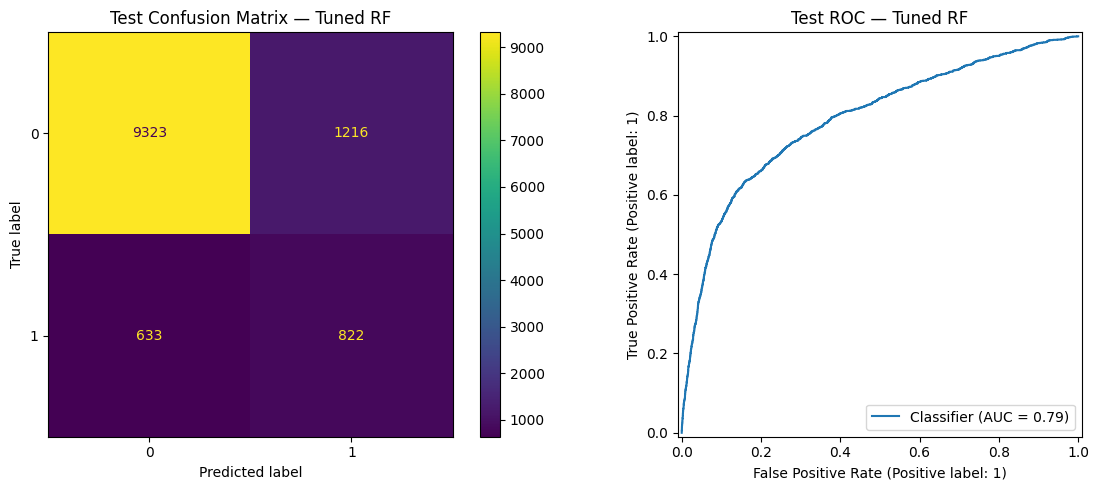

In [ ]:
# %% [code]
# %% [code] Final evaluation on the unseen Test set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:,1]

print_header("Unseen Test Metrics — Tuned RF")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("\nClassification report:\n", classification_report(y_test, y_test_pred))

# Create a figure with two subplots arranged side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Confusion Matrix on the first subplot
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axes[0])
axes[0].set_title("Test Confusion Matrix — Tuned RF")

# Plot ROC Curve on the second subplot
RocCurveDisplay.from_predictions(y_test, y_test_proba, ax=axes[1])
axes[1].set_title("Test ROC — Tuned RF")

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()